In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from functools import lru_cache
import os
from scipy.spatial.distance import pdist, squareform

In [ ]:
input_dim = 400
num_points = 50
hidden_dim = 128
batch_size = 128
epochs = 100
lr = 0.001

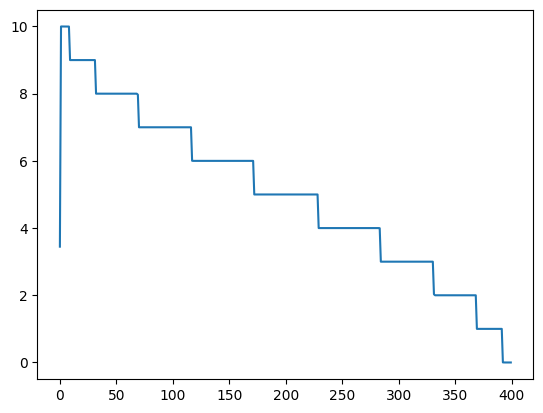

In [3]:
pris = np.loadtxt(os.path.expanduser('~/Downloads/transmissions/size_10/size_10_pris.csv'), delimiter=',')
plt.plot(pris)

In [4]:
size = 10
@lru_cache(maxsize=1024)
def configs(conc):
    df = {}
    for x in range(5000):
        path = os.path.expanduser(f'~/Downloads/transmissions/size_10/lead_size_10_conc_{conc}_config_{x}.csv')
        new_data = np.loadtxt(path, delimiter=',',skiprows=1)[:,1]
        df[x] = new_data
    df = pd.DataFrame(df)
#    df.index = np.arange(0, 4, 0.01)
    return df.clip(upper=size)


DEVICE_COMBS = {}

@lru_cache(maxsize=1024)
def chosen_for_config(n, size, config):
    width = int(size); n = int(n); cfg = int(config)
    if width not in DEVICE_COMBS:
        DEVICE_COMBS[width] = np.array([(i, j) for i in range(100) for j in range(width)], dtype=int)
    device_combs = DEVICE_COMBS[width]
    rng = np.random.RandomState(cfg)
    chosen_indices = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[chosen_indices]


def possible_combs(n, width):
    def combs_for_seed(x):
        return chosen_for_config(n, width, x)
    return combs_for_seed

@lru_cache(maxsize=1024)
def distance_matrix(conc,config):
    imps  = possible_combs(conc, size)
    item = imps(config)
    #print(np.diag(item[:,1]))
    x = np.stack((size - item[:,1],item[:,1]), axis=1)
    return squareform(pdist(item, metric='euclidean')) + np.diag(x.min(axis=1))

In [ ]:
def create_dataset():
    x = []
    y = []
    for conc in np.arange(7,50,2):
        print(f"Processing concentration: {conc}")
        for config in range(5000):
            dist_mat = 0 *np.eye(50)
            dist_mat[:conc,:conc] +=  distance_matrix(conc, config)
            path = os.path.expanduser(f'~/Downloads/transmissions/size_10/lead_size_10_conc_{conc}_config_{config}.csv')
            new_data = np.loadtxt(path, delimiter=',',skiprows=1)[:,1]
            #arr = configs(conc).index,configs(conc)[config]
            #arr = np.array(arr).T
            y.append(dist_mat)
            x.append(np.clip(new_data, 0, pris))


    x = np.array(x)
    y = np.array(y)
    print(f"Shape of x: {x.shape}")
    print(f"Shape of y: {y.shape}")

    return x,y

x,y = create_dataset()

In [5]:
print("Creating manifest file...")

# This will store the info for each s#ample
manifest_data = []
# Define the root directory where files are stored
root_dir = os.path.expanduser('~/Downloads/transmissions/size_10/')

# Use the same loops as your original script
for conc in np.arange(7, 50, 2):
    for config in range(5000):
        # We just construct the path, we don't load the file here
        path = f'lead_size_10_conc_{conc}_config_{config}.csv'
        full_path = os.path.join(root_dir, path)

        # Check if the file actually exists before adding it to the manifest
        if os.path.exists(full_path):
            manifest_data.append({
                "concentration": conc,
                "config_id": config,
                "filepath": path  # Store the relative path
            })

# Convert the list of data into a pandas DataFrame
manifest_df = pd.DataFrame(manifest_data)

# Save the manifest to a CSV file
manifest_df.to_csv("manifest.csv", index_label="id")

print(f"Done! Created manifest.csv with {len(manifest_df)} entries.")

Creating manifest file...
Done! Created manifest.csv with 110000 entries.


In [6]:
class transmissions_dataset(Dataset):
    def __init__(self,manifest_file, root_dir,matrix_size=50,pris_file='~/Downloads/transmissions/size_10/size_10_pris.csv'):
        #print("Initializing dataset...")
        self.manifest = pd.read_csv(manifest_file,index_col="id")
        self.root_dir = root_dir
        self.matrix_size = matrix_size
        self.pris = np.loadtxt(os.path.expanduser(pris_file), delimiter=',')
        #print("dataset_ready")

    def __len__(self):
    #    print("Getting length of dataset...")
       # print(f"Length: {len(self.manifest)}")
        return len(self.manifest)
    def __getitem__(self, idx):
        sample_info = self.manifest.iloc[idx]
        conc = sample_info['concentration']
        config = sample_info['config_id']
        filepath = os.path.join(self.root_dir, sample_info['filepath'])
    #    print(f"Loading data from {filepath}...")
    #    print(f"Concentration: {conc}, Config ID: {config}")


        #"Get distance matrix"
        dist_mat = 0 *np.eye(self.matrix_size)
        dist_mat[:conc,:conc] +=  distance_matrix(conc, config)
        y = torch.tensor(dist_mat, dtype=torch.float32)

        #"Get transmission data"
        new_data = np.loadtxt(filepath, delimiter=',',skiprows=1)[:,1]
        x = torch.tensor(np.clip(new_data, 0, self.pris), dtype=torch.float32)


        return x, y

In [7]:
dataset = transmissions_dataset(manifest_file='manifest.csv', root_dir=os.path.expanduser('~/Downloads/transmissions/size_10/'))

In [10]:
x,y = dataset[500]

In [11]:
y

tensor([[ 3.0000, 49.0918, 12.3693,  ...,  0.0000,  0.0000,  0.0000],
        [49.0918,  4.0000, 61.0000,  ...,  0.0000,  0.0000,  0.0000],
        [12.3693, 61.0000,  4.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=8, shuffle=True)

In [12]:
import matplotlib.pyplot as plt

In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

In [14]:
class distance_matrix_nn(nn.Module):
    def __init__(self, input_dim = 400, num_points = 50, hidden_dim = 256):
        super(distance_matrix_nn, self).__init__()
        self.input_dim = input_dim
        self.output_dim = num_points * num_points

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.output_dim)
        )

        self.softplus = nn.Softplus()

    def forward(self, x):
        out = self.net(x)
        out = self.softplus(out)
        D = out.view(-1,50,50)
        return D


In [30]:
def training_model(num_epochs, val_split, batch_size = 32):


    device = "cpu"
    model = distance_matrix_nn(400, num_points=50, hidden_dim=256)
    optimizer = optim.SGD(model.parameters(),lr=0.01)
        

    n_val = int(len(dataset) * val_split)

    n_train = len(dataset) - n_val

    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, shuffle=True, batch_size = 32)

    val_loader = DataLoader(val_ds, shuffle=False, batch_size = 32)

    model = model.to(device)
    

    train_loss = []

    val_loss = []



    for epoch in range(num_epochs):
        model.train()
        total_losdd = 0

        for step, (xb,yb) in enumerate(train_loader):
            xb,yb = xb.to(device),yb.to(device)

            preds = model(xb)

            loss = F.mse_loss(preds,yb)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            total_losdd += loss.item()

        avg_loss = total_losdd/len(train_loader)

        train_loss.append(avg_loss)



        print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.6f}")


        model.eval()

        val_loss_1 = 0

        with torch.no_grad():
            for xb,yb in val_loader:
                preds = model(xb)
                loss = F.mse_loss(preds,yb)
                val_loss_1 += loss.item()

        avg_val_loss = val_loss_1/ len(val_loader)

        val_loss.append(avg_val_loss)

        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_loss:.6f} | Val Loss: {avg_val_loss:.6f}")


        # -----------------
    plt.figure(figsize=(8,5))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()




    return model, (train_loss, val_loss)

In [ ]:
trained_model = training_model(100,0.2)

Epoch 001 | Loss: 492.418042
Epoch 001 | Train Loss: 492.418042 | Val Loss: 381.555322
Epoch 002 | Loss: 381.559329
Epoch 002 | Train Loss: 381.559329 | Val Loss: 381.464995
Epoch 003 | Loss: 381.364018
Epoch 003 | Train Loss: 381.364018 | Val Loss: 381.490178
Epoch 004 | Loss: 381.446773
Epoch 004 | Train Loss: 381.446773 | Val Loss: 381.450334
Epoch 005 | Loss: 381.287907
Epoch 005 | Train Loss: 381.287907 | Val Loss: 381.462051
Epoch 006 | Loss: 381.297356
Epoch 006 | Train Loss: 381.297356 | Val Loss: 381.446416
Epoch 007 | Loss: 381.348607
Epoch 007 | Train Loss: 381.348607 | Val Loss: 381.514298
Epoch 008 | Loss: 381.331386
Epoch 008 | Train Loss: 381.331386 | Val Loss: 381.466510
Epoch 009 | Loss: 381.292285
Epoch 009 | Train Loss: 381.292285 | Val Loss: 381.506732
Epoch 010 | Loss: 381.291807
Epoch 010 | Train Loss: 381.291807 | Val Loss: 381.517176
Epoch 011 | Loss: 381.274743
Epoch 011 | Train Loss: 381.274743 | Val Loss: 381.495868
Epoch 012 | Loss: 381.251203
Epoch 012 | Tr

In [ ]:
def offdiag_mse(pred, target):
    # pred, target: (B, N, N)
    N = pred.size(-1)
    eye = torch.eye(N, device=pred.device).bool()
    mask = ~eye  # off-diagonal True
    diff = pred - target
    diff = diff[:, mask]
    return (diff ** 2).mean()

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    losses = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        D = model(x)
        loss = offdiag_mse(D, y)
        losses.append(loss.item())
    return sum(losses) / len(losses)

In [ ]:
model = distance_matrix_nn(input_dim=input_dim, num_points=num_points, hidden_dim=hidden_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

best_val = float("inf")
for epoch in range(1, epochs + 1):
    model.train()
    running = 0.0
    for a, b in train_loader:
        a, b = a.to(device), b.to(device)
        
        D = model(a)
        loss = offdiag_mse(D, b)
        
        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # safe training
        opt.step()

        running += loss.item() * a.size(0)

    train_loss = running / len(train_loader.dataset)
    val_loss   = evaluate(model, val_loader, device)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_distance_model.pt")
    print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")


In [ ]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    losses = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        D = model(x)
        loss = offdiag_mse(D, y)
        losses.append(loss.item())
    return sum(losses) / len(losses)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Load best weights (optional)
#model.load_state_dict(torch.load("best_distance_model.pt", map_location="cpu"))
model.eval()

x_sample, y_true = next(iter(val_loader))
x_sample = x_sample.to("cpu")
with torch.no_grad():
    y_pred = model(x_sample)  # (B, N, N)

print("Pred shape:", y_pred.shape)
print("Example pred D[0]:\n", y_pred[0].cpu())
print("Example true D[0]:\n", y_true[0])


In [ ]:
y_pred[0].shape

In [ ]:
y_true[0].shape

In [ ]:
diff = y_pred[0] - y_true[0]

In [ ]:
diff.mean()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose y_pred, y_true are tensors of shape (B, 50, 50)
diff = y_pred[0] - y_true[0]    # first sample
diff = diff.detach().cpu().numpy()  # convert to NumPy if on GPU

plt.figure(figsize=(6,6))
plt.imshow(diff, cmap='bwr', interpolation='nearest')
plt.colorbar(label='Prediction error')
plt.title("Difference: Predicted - True")
plt.show()


In [ ]:
print("Max error:", np.max(diff))
print("Min error:", np.min(diff))
print("Mean absolute error:", np.mean(np.abs(diff)))
